# YOLO2 detailed

Compared with YOLO1, YOLO2 has proposed many solutions to improve the performance of the network, such as

(1) Batch regularization data

(2) Use higher resolution to detect small images

(3) Use priority boxes as a frame of reference to make learning easier

(4) Use the k-mean clustering algorithm to determine the number of anchor boxes that are more suitable for each grid.

(5) Limiting the prediction offset range between 0-1 makes the model more stable

(5) Change the size of the input image during training to adapt to the detection of objects of different resolutions

(6) Joint classification and detection data sets enable it to detect more than 9,000 types of objects, etc.

(7) Remove the last pooling layer and get a high-resolution output. Although the accuracy decreases, more frames can be predicted.

At the same time, it uses its own network DarkNet-19 instead of VGG.
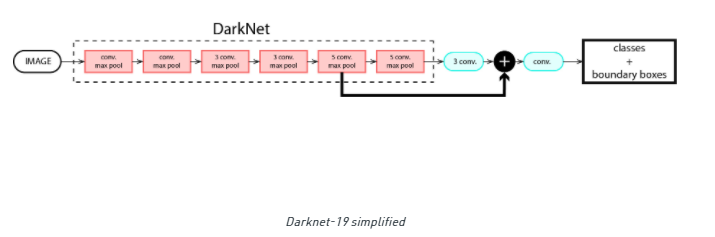

### 1. YOLO2 solves the limitation that most target detection models only predict a few types of objects, and can detect more than 9,000 different types of data . (YOLO1 only has 20 types)

Most target detection models can only predict objects of a small number of categories. The main reason is that labeling the target dataset is too expensive to achieve the size of the image classification dataset. YOLO2 proposes a joint training algorithm that can use the ImageNet classification data set with a large amount of data to expand the range of data detected by the target detection system , and use the labeled object detection data set COCO to learn to accurately locate the object, while using large classification data Set ImageNet to increase its generalization capabilities.


### 2. YOLO2 proposed many improved algorithms to improve the performance of the target detection model, as shown below:

### 3. Improved algorithm 1: batch normalization

BN not only standardizes the input layer, but also standardizes each input layer of the network. It is equivalent to forcing the distribution of the input value of any neuron in each layer of the neural network back to the standard normal distribution with a mean of 0 and a variance of 1. The benefits of this are:

(1) The gradient can be made larger to avoid the problem of gradient disappearance.

(2) A larger gradient means faster learning convergence and faster training.

(3) Improve the generalization ability of the model. Because batch normalization is not applied to the entire data set, some noise will be generated, thereby improving the generalization ability of the model.

### 4. Improved algorithm 2: training classification network with high resolution

The input image size of YOLO training classifier on ImageNet is 224 * 224, and when training the target detector, the resolution is increased to 448 * 448, so YOLO needs to do target detection and adapt to the new resolution at the same time. YOLO2 proposed that you can first train 10 iterations on ImageNet to fine-tune the classification network with 448 * 448 resolution images , which makes our target detection network better adapt to high-resolution inputs.

### 5. Improved algorithm three: borrowing RPN anchor boxes, with prior knowledge, network learning is easier

YOLOv1 finally uses a fully connected layer to directly predict the bounding box, where the width and height of the bounding box are relatively the size of the entire picture, and because there are objects of different scales and aspect ratios in each picture, there is no reference frame. It is difficult to learn to adapt to the shape of different objects during training, which also causes it to perform poorly in terms of accurate positioning.

Faster RCNN uses anchors, as long as it predicts the offset (the offset between the predicted value and the anchor box). RPN convolves the feature map obtained by the CNN feature extractor to predict the location Bounding boxes and confidence (whether or not they contain objects), and different locations and a priori boxes with different scales are set. RPN predicts the offsets of the bounding box relative to the prior box. Using the prior box makes the model easier to learn.

YOLOv2 borrows the prior box (prior boxes) strategy of the RPN network. YOLOv2 removes the fully connected layer in YOLOv1 and uses convolution and priority boxes to predict the bounding boxes. It is easier to learn with the reference frame.

(1) A pooling layer is removed to make the convolutional network obtain high-resolution output, and the size of the feature map is 14 * 14.

(2) Reduce the network image size to 416 * 416 (originally 448 * 448). This is done so that there can be an odd number of grid positions on the feature map, and the dimensions are odd, so that the center of the object has exactly one center grid. In particular, the center of a large object often occupies multiple grids, and we hope to predict it with one grid instead of multiple. The downsampling of the YOLO convolution layer is divided by 32 (5 times max pooling 2 ^ 5 = 32), so the input image is 416, so the feature map can get a 13 * 13 grid.

(3) Like YOLO, IoU using the prediction box and the true value, and also using the class conditional probability (class probability * confidence).

YOLO2 using anchor boxes has a slight decrease in accuracy, but it can predict more than 1000 boxes, while YOLO has only 98 (7 * 7 * 2).

### 6. Improved algorithm four: Use k-mean clustering algorithm to automatically select the more appropriate prior frame dimensions

The k-means algorithm uses the distance between data as a standard for measuring the similarity of data objects, and clusters the data into several groups through cluster analysis. 

When using YOLO with anchor boxes, two problems are encountered. The first is that the dimensions (length and width) of the anchor box need to be manually specified, with a certain degree of subjectivity. If the selected prior box dimensions are appropriate, the model is easier to learn and thus makes better predictions. Therefore, we use k-means clustering algorithm to let the bounding boxes automatically select the dimensions (length and width) that are more suitable for the prior box, and make faster and better predictions.
The criterion for judging the distance between classes cannot be the standard Euclidean distance, because it will cause large boxes to produce more errors than small boxes. Therefore, the custom distance matrix is:,
<img src = boxcenteroid.png>
centroid is the border selected as the center during clustering, box is the other border, and d is the "distance" between the two. The larger the IOU, the closer the "distance". . After experiments, we found that k = 5 (the number of clusters is 5) can make a compromise between model complexity and recall.

### 7. Improved algorithm five: The predicted offset is limited to a grid range, and the model is more stable.

When using YOLO with anchor boxes, the second problem encountered is that the model is unstable, especially in early iterations. Most of the instability comes from the prediction of the box position (x, y), because What it predicts is the offset between the prediction box and the anchor box. The prediction value t and the coordinates (x, y) of the anchor box are calculated as follows:
<img src = "txty.png">

Where tx and ty are the distance between the normalized prediction box and anchor box, tx * wa is the real distance, distance = prediction box-anchor box,

(Is the formula here a plus sign?) If tx = 1, it means that the entire frame is moved to the right by the width of an anchor box. Any anchor box can be moved to the image position. Random initialization of the model takes a long time To be stable.
YOLO2 does not directly predict the offset of the prior box anchor box and the prediction box bounding box like RPN, but like YOLO, it predicts the offset of the center of the prediction box relative to the grid unit. YOLO2 uses a logistic activation function The prediction value of the network (the offset of the center of the prediction frame relative to the grid unit) is limited to 0-1, so that the offset of the prediction frame will not exceed one grid, and the model is more stable. Each grid on the feature map predicts 5 (k = 5 in k-means) bounding boxes (piror boxes), and the grid predicts 5 values for each bounding boxes: tx, ty, tw, th, to.

### 8. Improved algorithm 6: propose a passthrough layer, which is good for small target detection

The input image size of YOLOv2 is 416 * 416. After 5 times of maxpooling, a feature map of 13 * 13 size is obtained, and convolution is used for prediction based on this feature map. A feature map of size 13 * 13 is sufficient for detecting large objects, but a finer feature map is also needed for small objects. Therefore, the SSD uses multi-scale feature maps to detect objects of different sizes. The more detailed feature maps in the front can be used to predict small objects. YOLOv2 proposes a passthrough layer to take advantage of finer feature maps. The Fine-Grained Features used by YOLOv2 is a feature map with a size of 26 * 26 (the input of the last maxpooling layer). For the Darknet-19 model, it is a feature map with a size of 26 * 26 * 512. The passthrough layer is similar to the shortcut of the ResNet network. It takes the higher-resolution feature map as an input, and then connects it to the lower-resolution feature map. The front feature map dimension 26x26 is twice as much as the back feature map 13 * 13. Passthrough is to directly divide the 26x26x512 image into four parts, LT, RT, LB, RB, and then concatenate to form a 13x13x2048 feature map. The 13 * 13 * 1024 feature maps are connected together to form a 13 * 13 * 3072 feature map, which is conducive to the detection of small targets.

### 9. Improved Algorithm Six: Multi-Scale Training

The size of the YOLO2 input image is 416 * 416. It hopes to improve the speed and robustness of the target detection by the network on images of different resolutions. The method is not to fix the size of the input image (FCN network), change the size of the input image every few iterations, and then continue training. Because our network downsampling needs to be divided by a factor of 32, we have to choose randomly at multiples of 32 (320, 352, ..., 608).

### 10. Network model (own model): Darknet-19

Similar to the vgg model, it mainly uses 3 × 3 filters and doubles the number of channels after each pooling step. After researching the network (NIN) in the network, use global average pooling ( a feature map gets a value after global average pooling, which will have many fewer parameters ). Predict and use a 1 × 1 filter to compress feature representations between 3 × 3 convolutions. Use batch normalized BNization to stabilize training, accelerate convergence, and normalize models. The final model, called darknet-19, has 19 convolutional layers and 5 maximum pool layers. The network structure is as follows:

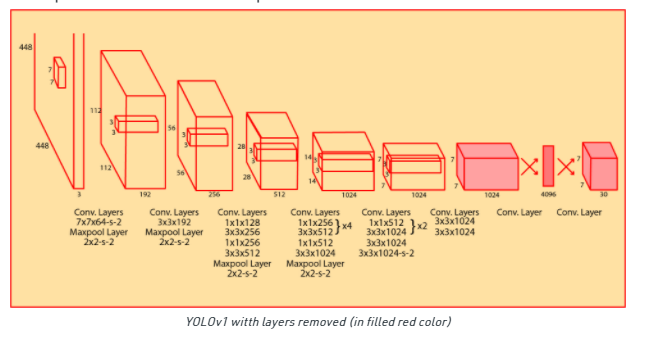

### 11.Training for classification

Using random gradient descent, the initial learning rate is 0.1, the fourth power of the polynomial decay rate is 0.1, the weight decay rate is 0.0005, and the momentum is 0.9. The network was trained on the standard ImageNet 1000 class classification dataset for 160 epochs. During training, use standard data enhancement techniques, including random crops, rotation, hue, saturation, and exposure offset. As mentioned above, after preliminary training on 224 × 224 images, the network is fine-tuned to a larger size, that is, 448 * 448. For this fine-tuning, use the above parameters for training, but train only 10 epochs, starting at a learning rate of 0.001.



### 12.Target detection network model

Delete the last convolutional layer, add 3 3 × 3 convolutional layers, each 3 * 3 convolutional layer is followed by a 1 * 1 convolutional layer, each convolutional layer has 1024 filters, and the last layer is 1 * 1 The number of convolution layer filters is equal to the number of network outputs to modify the network for detection tasks. Add another passthrough layer from the last 3 × 3 × 512 layer to the penultimate convolution layer 3 * 3 * 1024 so that the model can use fine-grained features. The network was trained for 160 epochs, with an initial learning rate of 0.001, which was divided by 10 at the 60th and 90th eopch, respectively.


### 13. Hybrid classification and detection data sets, joint training for classification and detection tasks

YOLO2 proposes a joint training mechanism that mixes images from detection and classification datasets for training. When the network sees the image marked for detection, it back-propagates based on the full yolov2 loss function. When it sees a classified image, it only back-propagates the loss from the classification-specific part. Use the WordTree method to combine the datasets, combine the COCO detection dataset with the first 9000 classes of the full ImageNet release to create our combined dataset. ImageNet is a much larger dataset, so we balance the dataset by oversampling COCO so that ImageNet is only a little larger than 4: 1. Through this joint training, Yolo9000 learned to use the detection data in Coco to find targets in the image, and learned to use the data in ImageNet to classify various targets.
